In [1]:
# lib
import sys

sys.path.append("..")

# set cwd one up
import os

os.chdir("..")
path = "../data/hes/Hes1_example.csv"


In [2]:
from gpcell import OscillatorDetector

In [3]:
osc = OscillatorDetector(path, "Time (h)", "Background", "Cell")
params = {"verbose": True}
osc.run(**params)

TypeError: OscillatorDetector.run() got an unexpected keyword argument 'verbose'

[0.05       0.         0.         0.         0.01666667 0.
 0.0125     0.         0.15       0.02222222 0.01428571 0.06363636]
[ True  True  True  True  True  True  True  True False  True  True False]
Number of cells counted as oscillatory (full method): 10/12


Text(0, 0.5, 'Frequency')

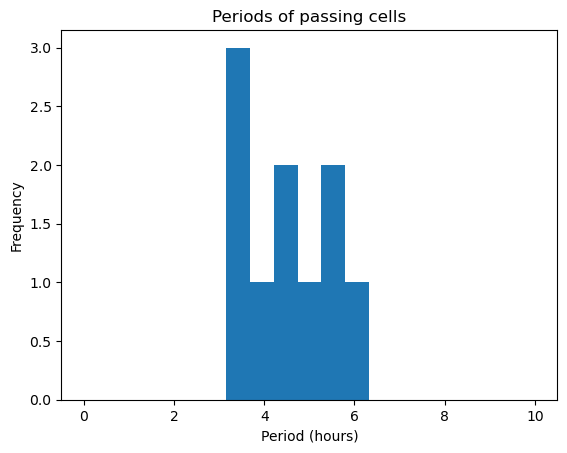

In [ ]:
LLR_list = osc.LLRs
LLR_list_synth = osc.synth_LLRs
period_list = osc.periods

import numpy as np
import matplotlib.pyplot as plt

LLR_array = np.array(LLR_list)
LLR_synth_array = np.array(LLR_list_synth)

# find indices where nan
nan_inds = np.isnan(LLR_array)
LLR_array = LLR_array[~nan_inds]
LLR_synth_array = LLR_synth_array[~np.isnan(LLR_synth_array)]

# LLRs can be tiny and just negative - this just sets them to zero
LLR_array[LLR_array < 0] = 0
LLR_synth_array[LLR_synth_array < 0] = 0

LLR_combined = np.concatenate((LLR_array, LLR_synth_array), 0)

upper = np.max(LLR_combined)
lower1 = np.min(LLR_combined)
lower = upper - 0.9 * (upper - lower1)
grid = np.linspace(lower, upper, 20)

piest = np.zeros_like(grid)

for i, cutoff in enumerate(grid):
    num = sum(LLR_array < cutoff) / len(LLR_array)
    denom = sum(LLR_synth_array < cutoff) / len(LLR_synth_array)
    piest[i] = num / denom

xx = np.linspace(lower, upper, 100)
from scipy.interpolate import CubicSpline

cs = CubicSpline(grid, piest)
yy = cs(xx)

piGUESS1 = yy[0]

I = np.argsort(LLR_array)

LLR_array_sorted = LLR_array[I]

q1 = np.zeros_like(LLR_array_sorted)

for i, thresh in enumerate(LLR_array_sorted):
    q1[i] = (
        piGUESS1
        * (sum(LLR_synth_array >= thresh) / len(LLR_synth_array))
        / (sum(LLR_array_sorted >= thresh) / len(LLR_array_sorted))
    )

q_vals = q1[np.argsort(I)]
osc_filt = q_vals < 0.05

print(q_vals)
print(osc_filt)

print(
    "Number of cells counted as oscillatory (full method): {0}/{1}".format(
        sum(osc_filt), len(osc_filt)
    )
)

period_array = np.array(period_list)[~nan_inds]
plt.hist(period_array[osc_filt], bins=np.linspace(0, 10, 20))
plt.title("Periods of passing cells")
plt.xlabel("Period (hours)")
plt.ylabel("Frequency")